# CE UQ - Sampling techniques and Monte Carlo simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Part 1. Sampling techniques

- use built-in functions to sample from independent RVs
- inverse sampling method
- what is a Markov chain? (used in MCMC)


### Use built-in functions to sample from 2 independent RVs

In python: use scipy.stats to create distribution objects, then samples realizations using the .rvs method

In [2]:
# Sample 2000 points (X, Y) where X, Y are independent RVs, X is Gaussian and Y is gamma distributed
from scipy.stats import norm, gamma
samples_x = norm(loc=1., scale=2.).rvs(size=(2000, ))
print(np.shape(samples_x))
samples_y = gamma(a=1.99).rvs(size=(2000, ))
samples = np.concatenate([samples_x.reshape((-1, 1)), samples_y.reshape((-1, 1))], axis=1)
print(np.shape(samples))

(2000,)
(2000, 2)


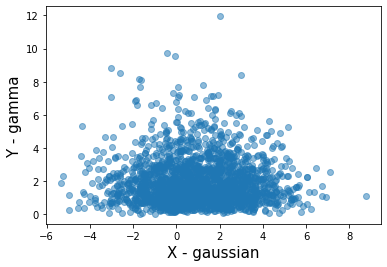

In [3]:
fig, ax = plt.subplots()
ax.scatter(samples_x, samples_y, alpha=0.5)
ax.set_xlabel('X - gaussian', fontsize=15)
ax.set_ylabel('Y - gamma', fontsize=15)
plt.show()

### Inverse sampling method

In [4]:
# function that samples from an exponential distribution (with lambda=3) using hte inverse sampling method
def sample_exponential_via_inverse_transform_sampling(nsamples):
    samples = np.empty((nsamples, ))
    for i in range(nsamples):
        u = np.random.rand()   # sample from U(0, 1)
        samples[i] = - np.log(1. - u) / 3.
    return samples
        
samples_test = sample_exponential_via_inverse_transform_sampling(nsamples=5)
print(samples_test)

[0.36335004 0.96143415 0.69255003 0.16842861 0.90575921]


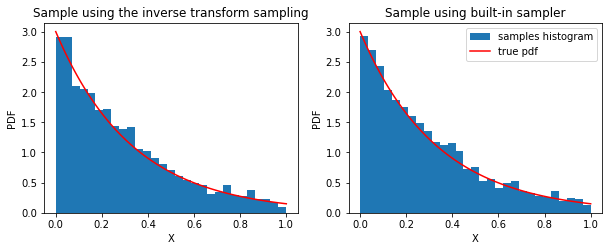

In [5]:
# compare this with using the built-in sampler
from scipy.stats import expon
x_values = np.linspace(0, 1., 100)
fig, ax = plt.subplots(ncols=2, figsize=(10, 3.5))

samples_1 = sample_exponential_via_inverse_transform_sampling(nsamples=3000)
ax[0].hist(samples_1, bins=np.linspace(0, 1., 30), density=True)
ax[0].plot(x_values, expon(scale=1/3).pdf(x_values), color='red')

samples_2 = expon(scale=1/3).rvs(size=(3000, ))
ax[1].hist(samples_2, bins=np.linspace(0, 1., 30), density=True, label='samples histogram')
ax[1].plot(x_values, expon(scale=1/3).pdf(x_values), color='red', label='true pdf')

for i in range(2):
    ax[i].set_xlabel('X')
    ax[i].set_ylabel('PDF')
ax[0].set_title('Sample using the inverse transform sampling')
ax[1].set_title('Sample using built-in sampler')
ax[1].legend()

plt.show()

### What is a Markov chain?

In [6]:
def propagate_markov_chain(x_previous):
    if x_previous == 'S':
        x_new = np.random.choice(['S', 'R'], p=[0.7, 0.3])
    else:
        x_new = np.random.choice(['S', 'R'], p=[0.4, 0.6])
    return x_new

In [7]:
x_previous = 'S'
for i in range(10):
    x_new = propagate_markov_chain(x_previous)
    print(x_new)
    x_previous = x_new

S
S
R
R
S
S
R
R
R
R


In [8]:
# run it for some time, and every time update the frequency of 'S' vs 'R'
N = 500

x_previous = 'N'
all_samples = []
frequency_S = []
for i in range(N):
    x_new = propagate_markov_chain(x_previous)
    all_samples.append(x_new)
    frequency_S.append(np.sum(np.array(all_samples) == 'S') / len(all_samples))
    x_previous = x_new

You can observe convergence to the limiting distribution p(S)=0.5714, p(R)=0.4286.

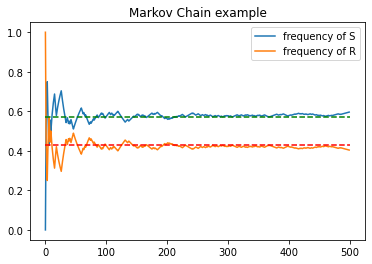

In [9]:
fig, ax = plt.subplots()
ax.plot(frequency_S, label='frequency of S')
ax.plot(1-np.array(frequency_S), label='frequency of R')
ax.plot([0, N], [0.5714, 0.5714], color='green', linestyle='--')
ax.plot([0, N], [0.4286, 0.4286], color='red', linestyle='--')
ax.legend()
ax.set_title('Markov Chain example')
plt.show()

MCMC algorithms build a Markov Chain whose limiting distribution is the distribution you're interested in sampling from. You will code a MCMC algorithm for Bayesian inference later in the course.

# Part 2. MC sampling

- standard MC simulation
- variance reduction: LHS
    
Let's look at a chemical reaction with integrated rate law:
$$ C(t) = C_0 e^{-kt} $$
where $t$ represents time, $C(t)$ is the concentration of the reactant at time $t$, $C_0$ is the initial concentration at time $t=0$ and $k$ is the rate constant. We assume both $C_0$ and $k$ are uniformly distributed between 0 and 1.

### Standard MC simulation

Sample independent realizations of input RVs (here $k, C_0$), then propagate them through forward model and evaluate distribution of output QoI (here $C(t)$ at t=2
min).

In [10]:
def evaluate_model(X):
    # X is a 2d matrix of size (nsamples x 2): 1st column contains samples from RV k, second column samples of C0
    ks, C0s = X[:, 0], X[:, 1]
    time = 2 # time we're interested in
    return C0s * np.exp(-ks * time)

In [11]:
# Sample from inputs
N_MC = 5000

X = np.random.uniform(low=0, high=1, size=(N_MC, 2))
Y = evaluate_model(X)
print(Y.shape)

(5000,)


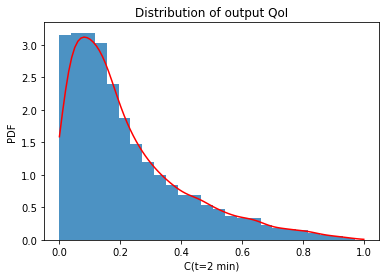

In [12]:
fig, ax = plt.subplots()
# histogram
ax.hist(Y, density=True, bins=25, alpha=0.8)
# kernel density estiamte of the PDF
from scipy.stats import gaussian_kde
kernel = gaussian_kde(Y)
yy = np.linspace(0, 1, 100)
ax.plot(yy, kernel(yy), color='red')
ax.set_xlabel('C(t=2 min)')
ax.set_ylabel('PDF')
ax.set_title('Distribution of output QoI')
plt.show()

### Variance reduction technique: LHS

LHS in uniform space: discretize the [0, 1] range in N equal-width bins, and get one sample from each bin. Repeat over all dimensions.

In [13]:
from scipy.stats import uniform
def lhs_uniform_in_2d(nsamples):
    # discretize the [0, 1] range in nsamples bins, and sample from each bin
    ind_bins_d1 = np.random.choice(nsamples, replace=False, size=nsamples)    # choose the bins for all the samples
    samples_d1 = uniform(loc=ind_bins_d1/nsamples, scale=1/nsamples).rvs().reshape((-1, 1))

    ind_bins_d2 = np.random.choice(nsamples, replace=False, size=nsamples)    # choose the bins for all the samples
    samples_d2 = uniform(loc=ind_bins_d2/nsamples, scale=1/nsamples).rvs().reshape((-1, 1))
    
    samples = np.concatenate([samples_d1, samples_d2], axis=1)
    return samples
# note: this is a highly inefficient way of sampling... just easy to read

(5, 2)


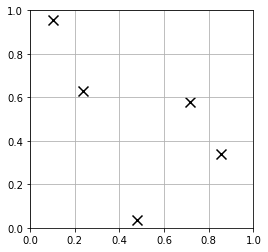

In [14]:
samples_lhs = lhs_uniform_in_2d(nsamples=5)
print(samples_lhs.shape)
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(samples_lhs[:, 0], samples_lhs[:, 1], marker='x', s=100, color='black')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 6))
ax.grid(True)
plt.show()

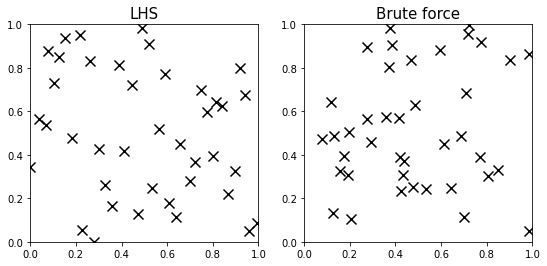

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 4))
nsamples = 40
# use lhs sampling
samples_lhs = lhs_uniform_in_2d(nsamples=nsamples)
ax[0].scatter(samples_lhs[:, 0], samples_lhs[:, 1], marker='x', s=100, color='black')
# use basic sampling instead
ax[1].scatter(np.random.rand(nsamples), np.random.rand(nsamples), marker='x', s=100, color='black')
for i in range(2):
    ax[i].set_xlim([0, 1])
    ax[i].set_ylim([0, 1])
ax[0].set_title('LHS', fontsize=15)
ax[1].set_title('Brute force', fontsize=15)
plt.show()

Let's transform these samples through a model h and see the results.

In [16]:
# let's repeat the process several times, compute the expected value of the functional exp(X1+X2) and see what happens
def compute_expected_functional(nsamples, use_lhs=True):
    if use_lhs:
        samples = lhs_uniform_in_2d(nsamples=nsamples)
    else:
        samples = np.random.rand(nsamples, 2)
    functional = evaluate_model(samples)    # compute functional for all samples
    return np.mean(functional), np.std(functional, ddof=1)    # return the sample mean, approxiamtes the expected value

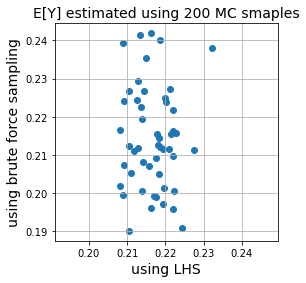

In [21]:
nsamples = 200

m1, m2 = [], []
s1, s2 = [], []
for _ in range(50):
    m, s = compute_expected_functional(nsamples, use_lhs=True)
    m1.append(m)
    s1.append(s)
    
    m, s = compute_expected_functional(nsamples, use_lhs=False)
    m2.append(m)
    s2.append(s)
    
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(m1, m2)
ax.set_title('E[Y] estimated using 200 MC smaples', fontsize=14)
ax.axis('equal')
ax.grid(True)
ax.set_xlabel('using LHS', fontsize=14)
ax.set_ylabel('using brute force sampling', fontsize=14)
plt.show()